## Install the Required Libraries

In [1]:
# !pip install wordcloud
# !pip install xgboost

## Import the Needed Libraries

In [2]:
import re
import nltk
import random
import pandas as pd
import numpy as np
from urllib import request
from nltk import pos_tag
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import wordcloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.text import TSNEVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import os
import multiprocessing
os.environ["OMP_NUM_THREADS"] = str(multiprocessing.cpu_count())
import warnings
warnings.filterwarnings('ignore')

## Download the Required Packages

In [3]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('omw-1.4') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esmae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\esmae\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\esmae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\esmae\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\esmae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\esmae\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 1 - PREPROCESSING

### Function to get the Wordnet's Part of Speach for future use to lemmatize the words

In [4]:
def get_word_net_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else :
        return wordnet.NOUN

## Function "read_book"


* **It Takes 3 parameters the URL of the Book, the Name of the book and the number of words for each book partition**
* **It Reads the Book, Decode, lower the Characters, Remove the Unnecessary characters, Remove the Stopwords, and Tokenize them**


* **It Gets 200 Random Samples each Consists of "word_num" Words** 
* **Then, Using the Previous "get_word_net_pos" Function we lemmatize the Tokens and Label the Book with its Author's name** 


* **Finally, We Return the Dataframe**








In [5]:
def read_book(url,name , word_num) :
    lemmatizer = WordNetLemmatizer()
    response = request.urlopen(url)
    lines = (response.read().decode('utf8')).lower()
    book = regexp_tokenize(lines,r'([a-zA-Z]{3,})[\,|\s|\.]') # words that are at least three characters long. It considers a word to end when it encounters either a comma, a whitespace character, or a period.
    tokens = [token for token in book if token.lower() not in stop_words]
    books =[]
    for i in range(200) :
        start = random.randint(0 , len(tokens) - word_num)
        books.append([' '.join(tokens[start: start + word_num])])    
    df = pd.DataFrame(books, columns=["partitions"])
    for i in range(200):
        sent=""
        x = nltk.pos_tag((df.partitions[i]).split())
        for word,tag in x:
            lemma = lemmatizer.lemmatize(word,pos=get_word_net_pos(tag))
            sent += lemma+" "
            df.partitions[i] = sent
    df["author"] = name
    return df

## Function "five_books"


*   **It Takes the List of URLs of the Books, the Authors List and the number of words for each partition as parameters**
*   **For each URL it Reads the Book and Preprocess it as Above then Append all of the Dataframes into a Full Dataframe that Contains all the Books Samples** 



In [6]:
def five_books(list_of_urls,author_list , word_num) :
    df_full = pd.DataFrame()
    for i,j in enumerate(list_of_urls) :
        df = read_book(j,author_list[i] , word_num)
        df_full = df_full.append(df , ignore_index= True)
    return df_full    

# 2-VISUALIZATION

## Function get_most_repeated_words
* **To Display the most Repeated n Words**  

In [7]:
def get_most_repeated_words(text, n):
    words = []
    for t in text:
        words.extend(t.lower().split())
    
    word_counts = Counter(words)
    most_common = word_counts.most_common(n)
    return most_common

## Function "draw_chart"
* **To show the Word Denisty for all Books**
* **It takes two parameters: the Data frame containing all books and the list of authors names**

In [8]:
def draw_chart(all_books, author_list, n=10):
    fig, axes = plt.subplots(nrows=len(author_list), ncols=2, figsize=(15, 6 * len(author_list)))
    plt.subplots_adjust(hspace=0.4)
    
    for i, author in enumerate(author_list):
        temp = all_books[all_books["author"] == author]["partitions"]
        
        wc = wordcloud.WordCloud(background_color='black', max_words=200, max_font_size=35)
        wc.generate_from_frequencies(dict(get_most_repeated_words(temp, 100)))
        
        axes[i, 0].imshow(wc, cmap=None)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Word Cloud - {author}')
        
        words = []
        for t in temp:
            words.extend(t.lower().split())
        
        word_counts = Counter(words)
        common_words = word_counts.most_common(n)
        df1 = pd.DataFrame(common_words, columns=['word', 'count'])
        
        sns.barplot(data=df1, x='word', y='count', ax=axes[i, 1], palette='coolwarm')
        axes[i, 1].set_title('Top {} Words - {}'.format(n, author))
        axes[i, 1].set_xlabel('Word')
        axes[i, 1].set_ylabel('Count')
        axes[i, 1].tick_params(axis='x', rotation=45)
        
    plt.show()

## Function "draw_chart_histogram"
 * **To Display the Characters' count for each Authors' Book**

In [9]:
def draw_chart_histogram(all_books):    
    x = "char_count"
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(x, fontsize=12)
    
    for i in all_books["author"].unique():
        sns.distplot(all_books[all_books["author"]==i][x], hist=True, kde=False, 
                     bins=10, hist_kws={"alpha":0.8}, 
                     axlabel="histogram", ax=ax[0])
        sns.distplot(all_books[all_books["author"]==i][x], hist=False, kde=True, 
                     kde_kws={"shade":True}, axlabel="density",   
                     ax=ax[1])
    ax[0].grid(True)
    ax[0].legend(all_books["author"].unique())
    ax[1].grid(True)
    plt.show()

# TRANSFORMATIONS

## Function bow 
 * **Convert the Text Dataframe into a Bag of Words Representation** 
 * **Then, Split the BOW Dataframe into Train and Test Sets** *italicized text*

In [10]:
def bow(df,test_size):
    vectorizer = CountVectorizer()
    bow_model = vectorizer.fit(df.partitions)
    X = bow_model.transform(df.partitions)
    df_bow = pd.DataFrame(X.toarray(),columns = bow_model.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(df_bow, Y,stratify=Y , test_size = test_size, random_state = 42)
    return X_train, X_test, y_train, y_test, df_bow

## Function tf_idf
* **Convert the Text Dataframe into a TF_IDF  Representation** 
* **Then, Split the TF_IDF Dataframe into Train and Test Sets**

In [11]:
def tf_idf(df,test_size):
    vectorizer = TfidfVectorizer()
    tf_idf_model = vectorizer.fit(df.partitions)
    tf_idf_out=tf_idf_model.transform(df.partitions)
    feature_names = tf_idf_model.get_feature_names_out()
    dense = tf_idf_out.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    X_train, X_test, y_train, y_test = train_test_split(df, Y,stratify=Y  , test_size =test_size, random_state = 42)
    return X_train, X_test, y_train, y_test,df 

## Function n_gram
 * **Convert the Text Dataframe into a N_Gram Representation specified by the "n" parameter given to the function**
 * **Then, Split the N_Gram Dataframe into Train and Test Sets**

In [12]:
def n_gram(df , n,test_size):
    count_vect = CountVectorizer(ngram_range=(n , n))
    ngram_vectors=count_vect.fit_transform(df.partitions)
    df = pd.DataFrame(ngram_vectors.toarray(),columns=count_vect.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(df, Y,stratify=Y  ,test_size =test_size, random_state = 42)

    return X_train, X_test, y_train, y_test,df

## Function "draw_TSNE"
* **To Display the Scatter plot for each Book To see the Similarity between these Books**

In [13]:
def draw_TSNE (df_input):
    tsne = TSNEVisualizer()
    tsne.fit(df_input,df["author"])
    tsne.show()
    

## cross_validation


* **this is a user defined function which takes estimator[fit],x_train and y_train**
* **then passes them to cross_val_score function to Evaluate a score by cross-validation.**
* **then return scores whice contain taining score and validation score**

In [14]:
cv =10
def cross_validation(model, X, y):
    scores = cross_val_score(model, X, y, cv=cv )
    return scores 

## confusion_mx

* **this is user defined function which take y_test , y_predict and model_name**

* **then path them to confusion_matrix function**
* **to draw and calculate confusion_matrix**

In [15]:
def confusion_mx(y_test, y_pred, model_name, i):
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 2, i)  # Adjust the subplot location
    sns.heatmap(cm, annot=True,fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{model_name} Confusion Matrix')


##  bar_plot_val


* **this is user defined function which take results [list contain train and validation score]**

* **then draw bar chart to visualize train and validation score**

In [16]:
def bar_plot_val(train_scores, test_scores, model_name, i):
    X_axis = np.arange(len(train_scores))
    width = 0.35
    plt.subplot(1, 2, i)  # Adjust the subplot location
    plt.bar((X_axis - width/2)+1, train_scores, width, color='blue', label='Train Score')
    plt.bar((X_axis + width/2)+1, test_scores, width, color='orange', label='Test Score')

    plt.xlabel('10 Folds')
    plt.ylabel('Score')
    plt.title(f'{model_name} Train and Test Scores')
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.yticks([ 0 , 0.2 , 0.4 , 0.6 , 0.8 , 1 , 1.2])
    plt.legend(loc = "best")
    plt.figure(figsize=(8, 6))

## generate_classification_report
### Print th eclassification report

In [17]:
def generate_classification_report(true_labels, predicted_labels):
    report = classification_report(true_labels, predicted_labels)
    return report 

## model_fit

* **this is user defined function which take X_train ,y_train ,X_test,y_test,model and model_name**

* **then path X_train and y_train to fit function then path X_test to  predict functoin to calculate  y_pred**

* **then path X_train , y_train and estimator with 10 k_fold  to cross_validate fun**

* **then path the results from cross_validate to bar_plot_val function** 

* **then path y_test ,y_pred and model_name**

In [18]:
def model_fit(X_train, y_train, X_test, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results = cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, return_train_score=True)
    train_scores, test_scores,  = results["train_score"] , results["test_score"]
    print(f"Score {model_name} ",end="")
    print()
    print(cross_validation(model,X_train,y_train))
    print()
    print(generate_classification_report( y_test , y_pred))
    print()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    confusion_mx(y_test, y_pred,model_name , 1)
    bar_plot_val(train_scores ,test_scores ,  model_name , 2)

## Svm

* **this is user defined function whice apply  SVM model  using \"rbf\" kernel**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [19]:
def Svm():
    Svc = SVC(kernel="rbf")
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, Svc,"SVM BOW")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,Svc,"SVM TF_IDF")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,Svc,"SVM 2_GRAM")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,Svc,"SVM 3_GRAM")


## NaiveBayes
  
* **this is user defined function whice apply  naive_bayes model**  
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [20]:
from sklearn.naive_bayes import MultinomialNB

def NaiveBayes():
    NaiveBayes = MultinomialNB()
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, NaiveBayes,"NaiveBayes BOW")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,NaiveBayes,"NaiveBayes TF_IDF")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,NaiveBayes,"NaiveBayes 2_GRAM")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,NaiveBayes,"NaiveBayes 3_GRAM")


## knn
* **this is user defined function whice apply  KNeighborsClassifier model  with k = 5**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [21]:
def knn():
    k = 5  # Set the value of k for KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, knn,"knn BOW")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,knn,"knn TF_IDF")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,knn,"knn 2_GRAM")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,knn,"knn 3_GRAM")


## RandomForest
* **this is user defined function whice apply  RandomForestClassifier model**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [22]:
def RandomForest():
    RandomForest = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 42)
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, RandomForest,"RandomForest BOW")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,RandomForest,"RandomForest TF_IDF")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,RandomForest,"RandomForest 2_GRAM")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,RandomForest,"RandomForest 3_GRAM")



## SGD
* **this is user defined function whice apply  SGDClassifier model**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [23]:
def SGD():
    SGD = SGDClassifier(random_state=42)
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, SGD,"SGD BOW")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,SGD,"SGD TF_IDF")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,SGD,"SGD 2_GRAM")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,SGD,"SGD 3_GRAM")



## XGB

* **this is user defined function whice apply  XGBClassifier model**
* **then calculate cross_validation for all three Transform\n**",
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [24]:
def XGB():
    XGB = xgb.XGBClassifier(random_state=42)
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, XGB,"XGB BOW")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,XGB,"XGB TF_IDF")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,XGB,"XGB 2_GRAM")
    print("______________________________________________________________________________________________________________________")
    print("______________________________________________________________________________________________________________________")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,XGB,"XGB 3_GRAM")


## Get 5 Books from Gutenberg Library 


*  **The Project Gutenberg EBook of The Adventures of Pinocchio, by C. Collodi--Pseudonym of Carlo Lorenzini**

*  **The Project Gutenberg eBook of Peter Pan, by James M. Barrie**

*  **The Project Gutenberg eBook of The Wonderful Wizard of Oz, by L. Frank Baum**

*  **The Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll**

*  **The Project Gutenberg eBook of Gulliver’s Travels, by Jonathan Swift**








In [25]:
pinocchio = "https://www.gutenberg.org/files/500/500-0.txt"
pan = "https://www.gutenberg.org/files/16/16-0.txt"
oz = "https://www.gutenberg.org/files/55/55-0.txt"
alice = "https://www.gutenberg.org/files/11/11-0.txt"
gulliver = "https://www.gutenberg.org/files/829/829-0.txt"
books_list = [pinocchio , pan , oz , alice , gulliver]
author_list = ["Carlo Collodi", "James M. Barrie", "L. Frank Baum", "Lewis Carroll", "Jonathan Swift"]

In [26]:
df = five_books(books_list,author_list, 30)

In [27]:
df['char_count'] = df["partitions"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df.head()

,partitions,author,char_count
0,best could poor marionette without penny pocke...,Carlo Collodi,144
1,marionette nose chin pull unmercifully side si...,Carlo Collodi,153
2,stop wait right moment make escape want know s...,Carlo Collodi,146
3,call pinocchio star dance theater light day ni...,Carlo Collodi,160
4,agreement agreement shall interpret make maxim...,Carlo Collodi,229


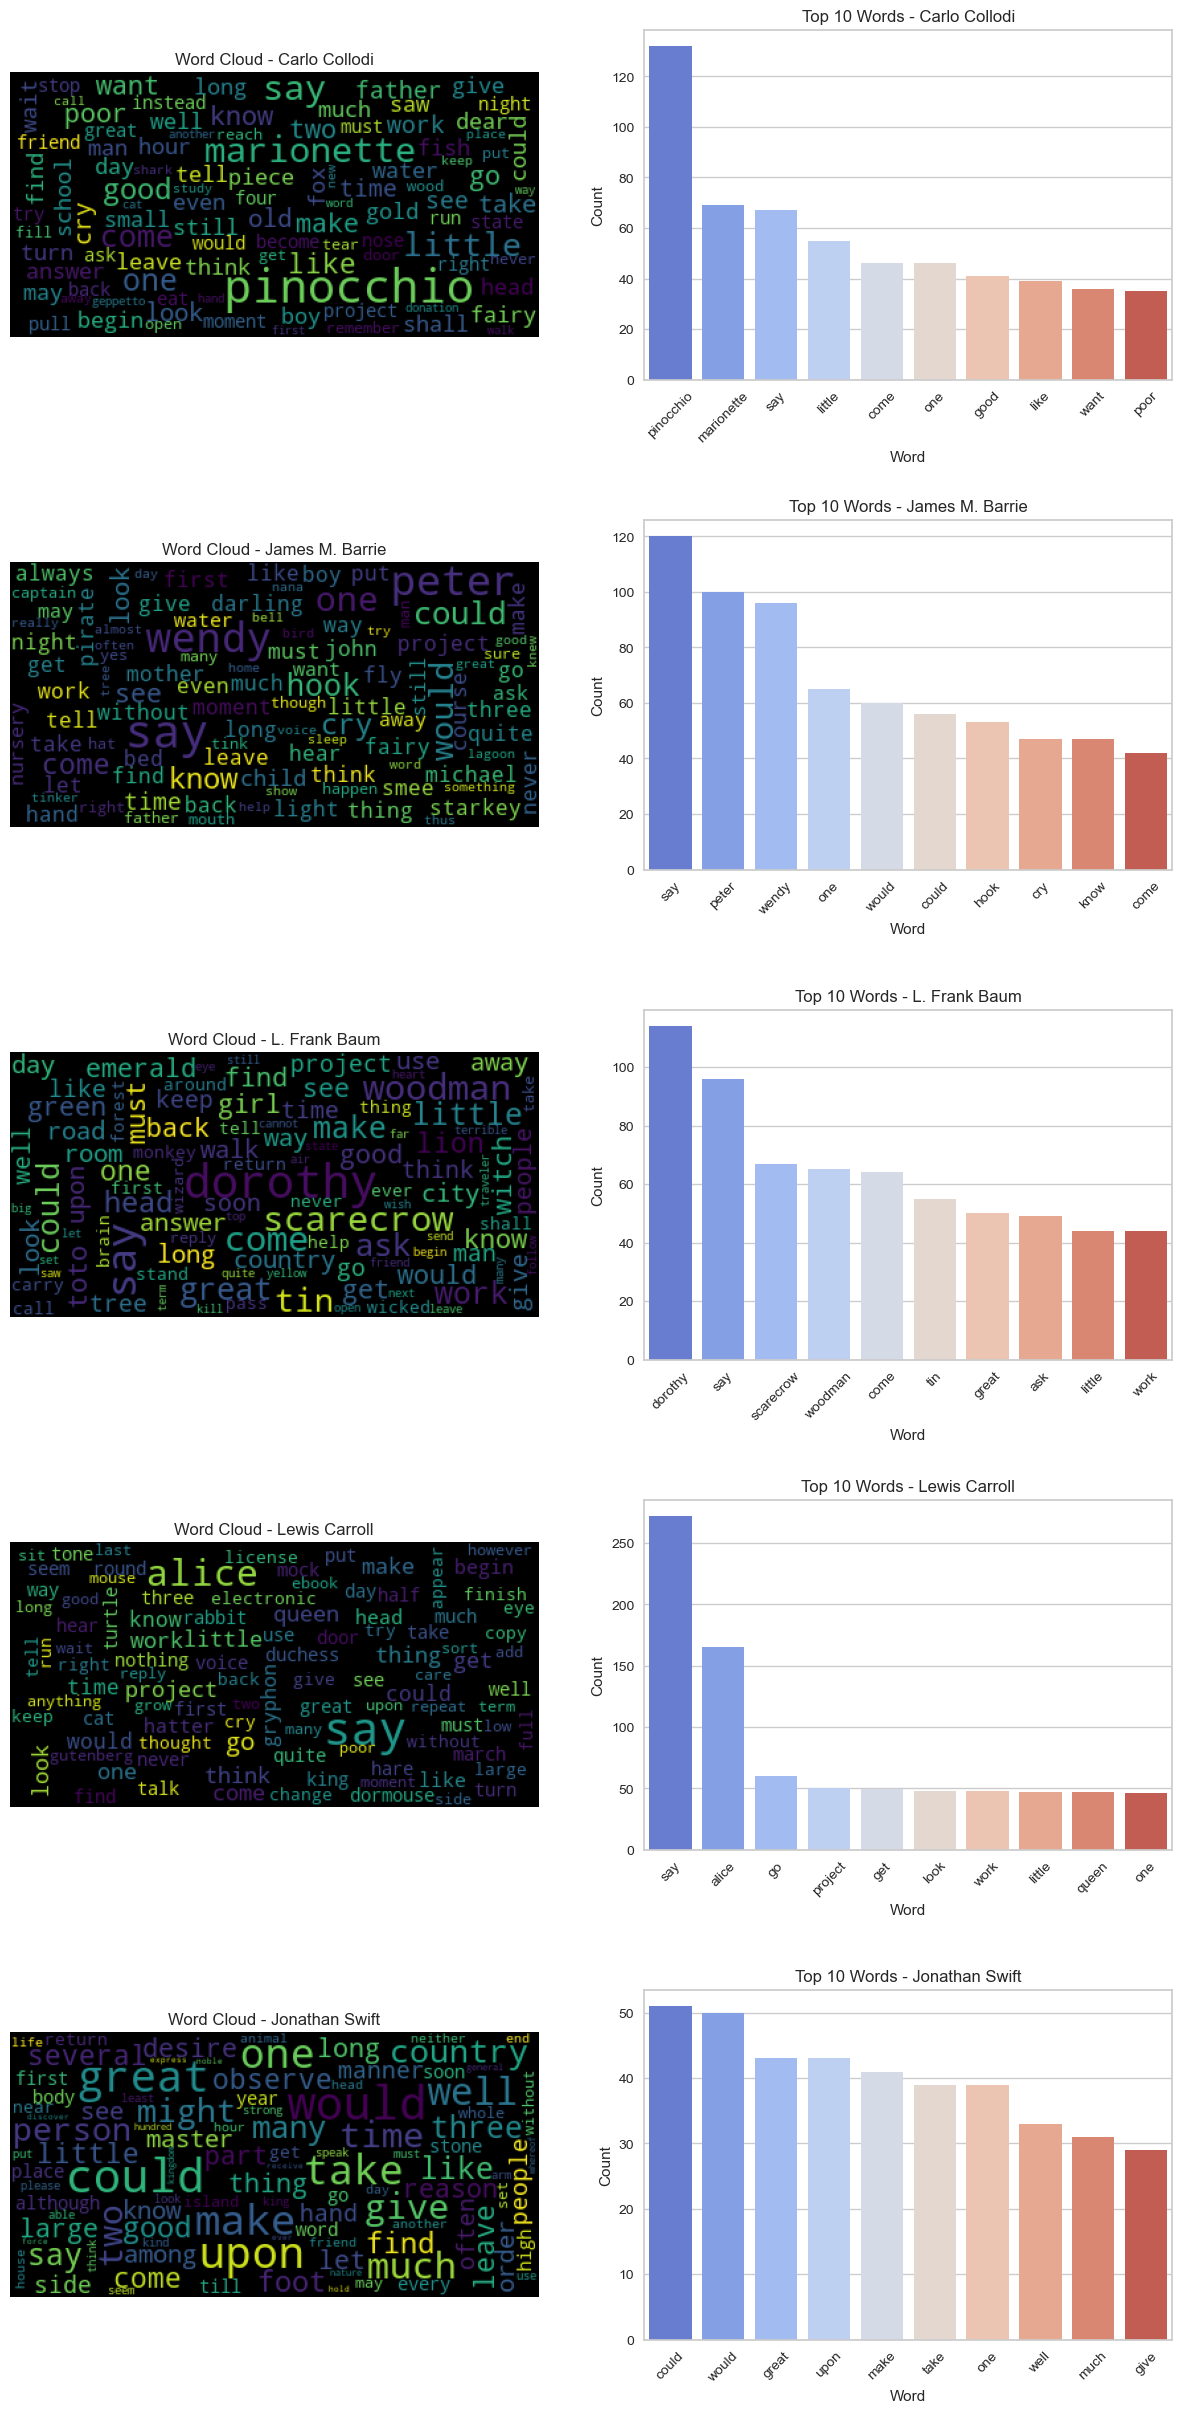

In [28]:
draw_chart(df,author_list)

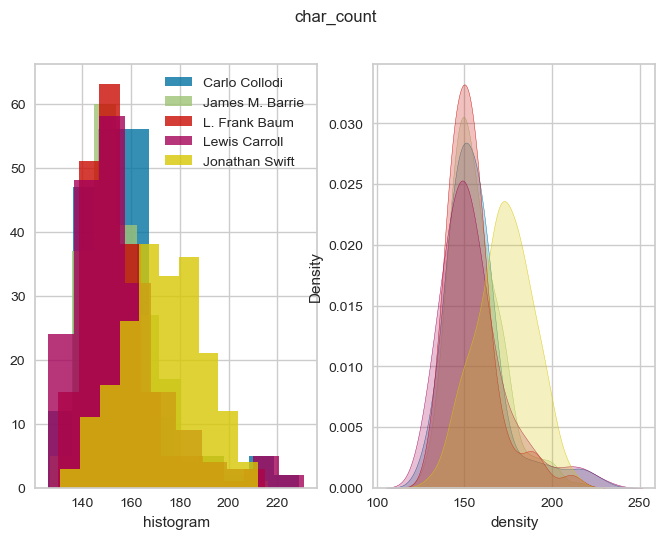

In [29]:
draw_chart_histogram(df)

In [30]:
Y = df.author
Y

0       Carlo Collodi
1       Carlo Collodi
2       Carlo Collodi
3       Carlo Collodi
4       Carlo Collodi
            ...      
995    Jonathan Swift
996    Jonathan Swift
997    Jonathan Swift
998    Jonathan Swift
999    Jonathan Swift
Name: author, Length: 1000, dtype: object

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

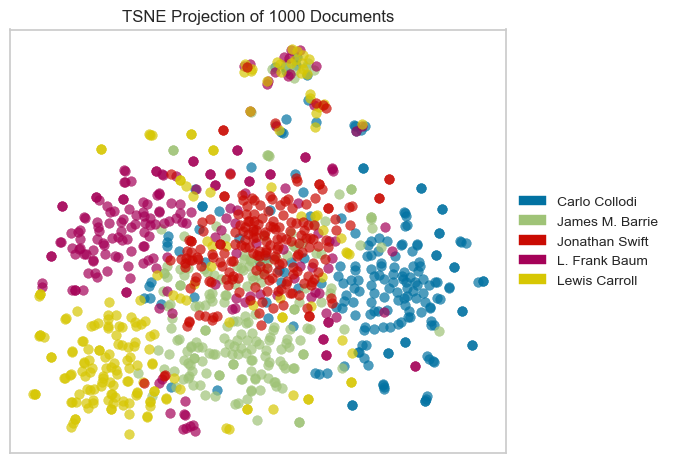

In [31]:
BOW_df = bow(df,0.2)
draw_TSNE(BOW_df[4])

In [ ]:
TF_IDF_df = tf_idf(df,0.2)
draw_TSNE(TF_IDF_df[4])

In [ ]:
df_2_gram = n_gram(df,2,0.2)
draw_TSNE(df_2_gram[4])

In [ ]:
df_3_gram = n_gram(df,3,0.2)
draw_TSNE(df_3_gram[4])

In [ ]:
encoder = LabelEncoder()
df.author = encoder.fit_transform(df.author)
Y = df.author
Y

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow , hh = BOW_df
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf , tt = TF_IDF_df
X_train_n_gram, X_test_n_gram, y_train_n_gram, y_test_n_gram , gg = df_2_gram
X_train_3_gram, X_test_3_gram, y_train_3_gram, y_test_3_gram , gg = df_3_gram

In [ ]:
Svm()

In [ ]:
NaiveBayes()

In [ ]:
knn()

In [ ]:
RandomForest()

In [ ]:
SGD()

In [ ]:
XGB() 

# SECOND TRY

In [ ]:
BOW_df = bow(df,0.15)
draw_TSNE(BOW_df[4])

In [ ]:
TF_IDF_df = tf_idf(df,0.15)
draw_TSNE(TF_IDF_df[4])

In [ ]:
df_2_gram = n_gram(df,2,0.15)
draw_TSNE(N_gram_df[4])

In [ ]:
df_3_gram = n_gram(df,3,0.15)
draw_TSNE(df_3_gram[4])

In [ ]:
encoder = LabelEncoder()
df.author = encoder.fit_transform(df.author)
Y = df.author
Y

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow , hh = BOW_df
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf , tt = TF_IDF_df
X_train_n_gram, X_test_n_gram, y_train_n_gram, y_test_n_gram , gg = df_2_gram
X_train_3_gram, X_test_3_gram, y_train_3_gram, y_test_3_gram , gg = df_3_gram

In [ ]:
Svm()

In [ ]:
NaiveBayes()

In [ ]:
knn()

In [ ]:
RandomForest()

In [ ]:
SGD()

In [ ]:
XGB() 